In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential,mixed_precision
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Dropout, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomZoom,RandomBrightness
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

os.chdir('/tf-acno-projects/image-classification/')
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

2024-12-05 11:55:36.606464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 11:55:36.606507: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 11:55:36.606522: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 11:55:36.611411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.optimizer.set_jit(True)  # Enable XLA
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)]  # Limit GPU memory usage
            )
            print(f"Memory limit set for GPU")
    except RuntimeError as e:
        print(e)
        
# Before training
mixed_precision.set_global_policy('mixed_float16')
print("\nXLA Status Check:")
print(f"XLA JIT enabled: {tf.config.optimizer.get_jit()}")
print(f"XLA devices: {tf.config.list_logical_devices('XLA_GPU')}")

Memory limit set for GPU
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050, compute capability 8.6

XLA Status Check:
XLA JIT enabled: autoclustering
XLA devices: [LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU')]


2024-12-05 11:55:38.804053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-05 11:55:38.809665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-05 11:55:38.809696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-05 11:55:38.810657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-05 11:55:38.819723: I tensorflow/compile

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
data_dir = 'faces_data/'
input_shape=(128,128,3)

In [4]:
data_augmentation = Sequential([
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomFlip("horizontal"),
    RandomBrightness(0.1),
])

In [5]:
def prepare_dataset(ds, batch_size, is_training=True):

    # Normalize images
    ds = ds.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=AUTOTUNE
    )

    if is_training:
        ds = ds.shuffle(4000)
        
    ds = ds.batch(batch_size)
        
    return ds.prefetch(AUTOTUNE)

In [6]:
# data_aug images
"""
if is_training:
    ds = ds.map(
        lambda x,y: (data_augmentation(x,training=True),y),
        num_parallel_calls=AUTOTUNE
    )"""

'\nif is_training:\n    ds = ds.map(\n        lambda x,y: (data_augmentation(x,training=True),y),\n        num_parallel_calls=AUTOTUNE\n    )'

In [7]:
def get_class_distribution(dataset):
    class_counts = tf.zeros(5, dtype=tf.int32)
    for _, labels in dataset:
        class_counts += tf.cast(labels, tf.int32) # each individual sample's label in the dataset ; ( use reduce_sum if it was batched)
    return class_counts.numpy()


In [8]:
def plot_training_history(train_acc,val_acc,train_loss,val_loss):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [9]:
def create_model1():
       regularization_value = 0.0001    
       model = Sequential([
              Conv2D(16,(3,3),
                     strides=1,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value),
                     input_shape = input_shape
                     ),
              MaxPooling2D(),
              Conv2D(32,(3,3),
                     strides=1,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              MaxPooling2D(),
              Conv2D(16,(3,3),
                     strides=1,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              MaxPooling2D(),
              Flatten(),
                     
              Dense(64,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              Dropout(0.4),
              Dense(32,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              Dropout(0.2),
              Dense(5,
                     activation='softmax',
                     #kernel_initializer='glorot_uniform'
                     )
       ])
       return model

In [10]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(128, 128),
    label_mode='categorical',# Ensure labels are one-hot encoded
    batch_size= None,
)

# Check class names and indices
class_names = dataset.class_names
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}, Index: {i}\n")
    

Found 4640 files belonging to 5 classes.
Class: angry, Index: 0

Class: disgusted, Index: 1

Class: happy, Index: 2

Class: sad, Index: 3

Class: shocked, Index: 4



In [11]:
DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy()
# Define the sizes of your splits
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)

# Split the dataset
train_dataset = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

In [12]:
# Get one batch of data
for images, labels in train_dataset.take(1):  # Take 1 batch
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels:", labels.numpy())  # Convert to numpy array for easier viewing

# Check the unique values in labels to determine the format
unique_labels = tf.unique(tf.reshape(labels, [-1]))  # Flatten labels to check unique values
print("Unique label values:", unique_labels.y.numpy())

Images shape: (128, 128, 3)
Labels shape: (5,)
Labels: [0. 0. 1. 0. 0.]
Unique label values: [0. 1.]


In [13]:
train_dist = get_class_distribution(train_dataset)
print("\nClass distribution in training set:")
for i, count in enumerate(train_dist):
    print(f"Class {i}: {count} samples")

# Calculate class weights
total_samples = sum(train_dist)
n_classes = len(train_dist)
class_weights = {
    i: total_samples / (n_classes * count) if count> 0 else 0 for i, count in enumerate(train_dist)
}

print("\nClass weights:")
for class_idx, weight in class_weights.items():
    print(f"Class {class_idx}: {weight:.2f}")


Class distribution in training set:
Class 0: 1236 samples
Class 1: 387 samples
Class 2: 989 samples
Class 3: 519 samples
Class 4: 581 samples

Class weights:
Class 0: 0.60
Class 1: 1.92
Class 2: 0.75
Class 3: 1.43
Class 4: 1.28


In [14]:
callbacks = [
    #EarlyStopping(monitor='val_loss',patience=20,min_delta=0.00001),
    ReduceLROnPlateau(monitor="val_loss",factor=0.8, patience=5,min_delta=0.001,min_lr=1e-5),
]

In [56]:
input_shape = (128,128,3)
batch_sizes = [32]
learning_rates=[0.0005,0.0007,0.0009,0.0010]
Epochs = 100
results1 = []

train_datasets = [prepare_dataset(train_dataset, batch_size) for batch_size in batch_sizes]
val_datasets = [prepare_dataset(val_dataset, batch_size, is_training=False) for batch_size in batch_sizes]

In [57]:
for i, batch_size in enumerate(batch_sizes):
    train_ds = train_datasets[i]
    val_ds = val_datasets[i]
    
    for lr in learning_rates:
        tf.keras.backend.clear_session()

        model1 = create_model1()

        model1.compile(
            optimizer=Adam(learning_rate=lr),
            loss=CategoricalCrossentropy(),
            metrics=['accuracy'])
 
        training_history1 = model1.fit(
            train_ds,
            epochs=Epochs,
            validation_data=val_ds,
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=0)

        # Evaluate on validation set
        val_loss1, val_accuracy1 = model1.evaluate(val_ds, verbose=0)

        print(f"FOR Batch : {batch_size} , LR : {lr} we have \tEpochs : {len(training_history1.history['loss'])} Val Accuracy : {val_accuracy1:.4f} , Val Loss : {val_loss1:.4f}")

        results1.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_accuracy1,
            'val_loss': val_loss1,
            'history':training_history1.history
        })

FOR Batch : 32 , LR : 0.0005 we have 	Epochs : 100 Val Accuracy : 0.9397 , Val Loss : 0.1974
FOR Batch : 32 , LR : 0.0007 we have 	Epochs : 100 Val Accuracy : 0.9267 , Val Loss : 0.2083
FOR Batch : 32 , LR : 0.0009 we have 	Epochs : 100 Val Accuracy : 0.9332 , Val Loss : 0.2399
FOR Batch : 32 , LR : 0.001 we have 	Epochs : 100 Val Accuracy : 0.9159 , Val Loss : 0.2448


#### remark:
- High lr works better for big batch size
- Low lr works better for small batch size

In [58]:
best_result = min(results1, key=lambda x: x['val_loss'])

best_result_hist = best_result['history']

print("\nBest parameters:")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Learning Rate: {best_result['learning_rate']:.4f}")
print(f"Validation Accuracy: {best_result['val_accuracy']:.4f}")
print(f"Validation Loss: {best_result['val_loss']:.4f}")
print(f"Accuracy: {best_result_hist['accuracy'][-1]:.4f}")
print(f"Loss: {best_result_hist['loss'][-1]:.4f}")


Best parameters:
Batch Size: 32
Learning Rate: 0.0005
Validation Accuracy: 0.9397
Validation Loss: 0.1974
Accuracy: 0.8877
Loss: 0.2755


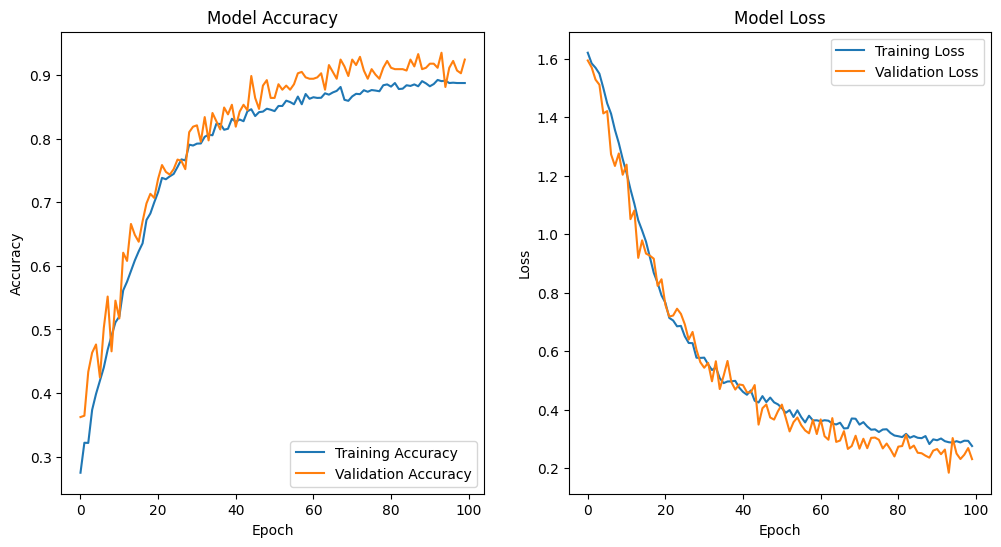

In [59]:
plot_training_history(best_result_hist['accuracy'],best_result_hist['val_accuracy'],best_result_hist['loss'],best_result_hist['val_loss'])

In [60]:
# Train final model with best parameters
tf.keras.backend.clear_session()
final_train_batches = prepare_dataset(train_dataset, best_result['batch_size'])
final_val_batches = prepare_dataset(val_dataset, best_result['batch_size'], is_training=False)

final_model1 = create_model1()

final_model1.compile(optimizer=Adam(learning_rate=best_result['learning_rate']),loss='categorical_crossentropy',metrics=['accuracy'])

final_history1 = final_model1.fit(final_train_batches,epochs=150,validation_data=final_val_batches,class_weight=class_weights,callbacks=callbacks,verbose=0)

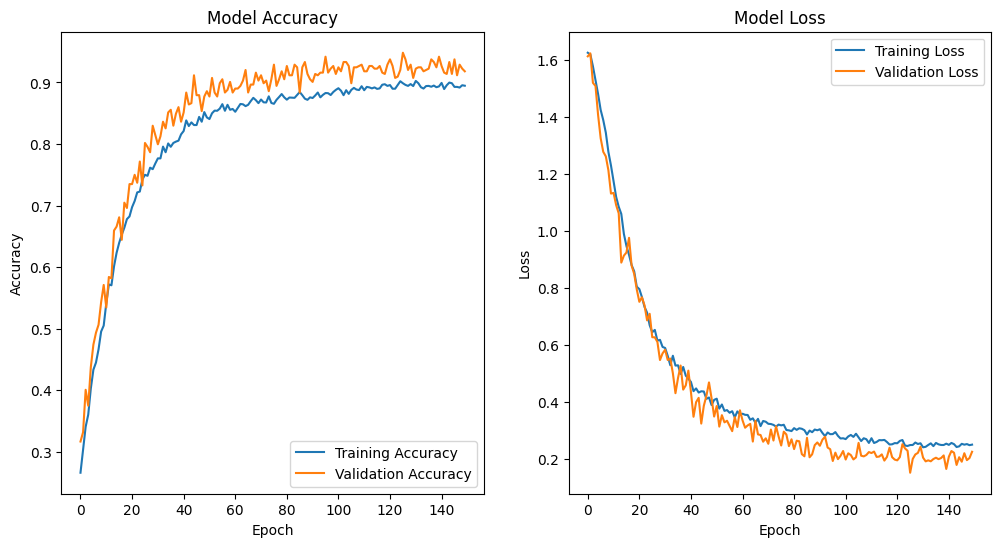

In [54]:
# plot of the training accuracy and loss
plot_training_history(final_history1.history['accuracy'],final_history1.history['val_accuracy'],final_history1.history['loss'],final_history1.history['val_loss'])

In [55]:
# Evaluate on test set
final_test_batches = prepare_dataset(test_dataset, best_result['batch_size'],is_training=False)

test_loss, test_accuracy = final_model1.evaluate(final_test_batches)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f},Final Test Loss: {test_loss:.4f}")

15/15 [==============================] - 0s 3ms/step - loss: 0.2040 - accuracy: 0.9246

Final Test Accuracy: 0.9246,Final Test Loss: 0.2040


#### Old 
- Final Test Accuracy: 0.9250,
- Final Test Loss: 0.1644
---
#### after adding class weights:
- Final Test Accuracy: 0.9138,
- Final Test Loss: 0.2299

### New model one
- Final Test Accuracy: 0.8642,
- Final Test Loss: 0.3685

### another train 05/12/2024

- Final Test Accuracy: 0.9353,
- Final Test Loss: 0.2214


- Final Test Accuracy: 0.9246,
- Final Test Loss: 0.2040

In [45]:
day_save_model_number = 0

In [46]:
year,month,day = str(datetime.now().year),str(datetime.now().month),str(datetime.now().day)
saved_date = year+'_'+month+'_'+day
test_accuracy = str(round(test_accuracy,3))
print(test_accuracy)

0.912


In [47]:
day_save_model_number = str(day_save_model_number+1)

In [48]:
keras_model_name = day_save_model_number+'_'+saved_date+'_'+test_accuracy+'.keras'
final_model1.save(os.path.join('models',keras_model_name))